# Portfolio Optmization
References:
- https://youtu.be/9GA2WlYFeBU
- https://ryanoconnellfinance.com/python-portfolio-optimization/

## Import required libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize

## Section 1: Define Tickers and Time Range

In [4]:
# Define the list od tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

- SPY is the most popular S&P 500 index
- BND is one of the most popular bond index
- GLD is one of the most popular commodity based index
- QQQ for the biggest NASDAQ ticker
- VTI provides a broad exposure to the U.S. equity market

In [5]:
# Set the end date to today
end_date = datetime.today()
end_date

datetime.datetime(2024, 3, 2, 0, 16, 20, 378927)

In [6]:
# Set the start date to 5 years ago
start_date = end_date - timedelta(days = 5*365)
start_date

datetime.datetime(2019, 3, 4, 0, 16, 20, 378927)

## Section 2: Download Adjusted Close Prices

In [7]:
# Create an empty DataFrame to store the adjusted close prices
adj_close_df = pd.DataFrame()

The adjusted close price is more accurate because it takes dividends, stock splits, and new stock offerings into account (the close price would underweight a portfolio that pays more dividends, for example).

In [9]:
# Download the close prices for each ticker
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date, progress = False)
    adj_close_df[ticker] = data['Adj Close']

In [11]:
# Show the df
adj_close_df.head()

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-03-04,257.485626,70.053101,121.559998,168.771881,132.465271
2019-03-05,257.135406,70.105919,121.720001,168.897629,132.216476
2019-03-06,255.577957,70.194038,121.610001,167.939682,131.212051
2019-03-07,253.439987,70.396614,121.510002,165.878677,130.189194
2019-03-08,252.933075,70.484711,122.839996,165.627106,129.921997


## Section 3: Calculate Lognormal Returns

Lognormal returns are additive over time, making them useful for certain types of financial modeling and analysis. So, if you have a series of lognormal returns for consecutive periods, you can simply sum them up to get the total return over that entire period, making it easier to analyze the cumulative effect of returns over time.

In [12]:
# Calculate the lognormal returns for each ticker
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [13]:
# Drop any missing values
log_returns = log_returns.dropna()

In [32]:
log_returns.head()

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-03-05,-0.001361,0.000754,0.001315,0.000745,-0.001880
2019-03-06,-0.006075,0.001256,-0.000904,-0.005688,-0.007626
2019-03-07,-0.008400,0.002882,-0.000823,-0.012348,-0.007826
2019-03-08,-0.002002,0.001251,0.010886,-0.001518,-0.002054
2019-03-11,0.014397,-0.000500,-0.004896,0.020585,0.014575


## Section 4: Calculate Covariance Matrix

In [14]:
# Calculate the covariance matrix using the annualized log returns
cov_matrix = log_returns.cov() * 252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.044190,0.002758,0.003623,0.049769,0.045253
BND,0.002758,0.004673,0.003898,0.003373,0.002938
GLD,0.003623,0.003898,0.022345,0.004899,0.003803
QQQ,0.049769,0.003373,0.004899,0.064604,0.050918
VTI,0.045253,0.002938,0.003803,0.050918,0.046717


## Section 5: Define Portfolio Performance Metrics

In [15]:
# Calculate the portfolio standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)
# @ to multiply matrix

The above line of code calculates the portfolio variance, which is a measure of the risk associated with a portfolio of assets. It represents the combined volatility in the portfolio, taking into account their individual volatilities and correlations with each other.

In [16]:
# Calculate the expected return
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

(*) Key Assumption: expected returns are based on historical returns

In [17]:
# Calculate the Sharpe Ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Sharpe Ratio = (Portfolio Return - Risk Free Rate) / St. Deviation

## Section 6: Portfolio Optimization

### Set the risk-free rate

Request FRED API key: https://fredaccount.stlouisfed.org/apikey

In [20]:
# Import
from fredapi import Fred

In [21]:
# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key = 'your_api_key')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

In [22]:
# Set the risk-free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
risk_free_rate

0.0421

### Define the function to minimize (negate Sharpe Ration)

In [23]:
# In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

### Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must by equal to 1. The constraints variable is a dictionary of two keys: 'type' and 'fun'. 'Type' is set to 'eq', which means 'equality constraints'. And 'fun' is assigned to the function 'check_sum', which checks if the sum of the portfolio weights is equal to 1.

Bonds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight should be between 0 and 0.5 (no negative values --> we cannot go short or sell on any of these assets; do not depend too much on outperformed assets, prioritize diversification).

In [24]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

### Set the initial weights

In [25]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

### Optimize the weights to maximize the Sharpe Ratio

'SLSQP' stands for Sequential Least Square Quadratic Programming, which is a numerical optimization technique suitable for solving optimization problems with constraints.

In [26]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [27]:
optimal_weights = optimized_results.x

## Section 7: Analyze the Optimal Portfolio

We calculate the expected annual return, expected volatility, and Sharpe ratio for the optimal portfolio.

### Display analytics of the optimal portfolio

In [28]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000
Expected Annual Return: 0.1424
Expected Volatility: 0.1606
Sharpe Ratio: 0.6245


### Display the Final Portfolio in a Plot

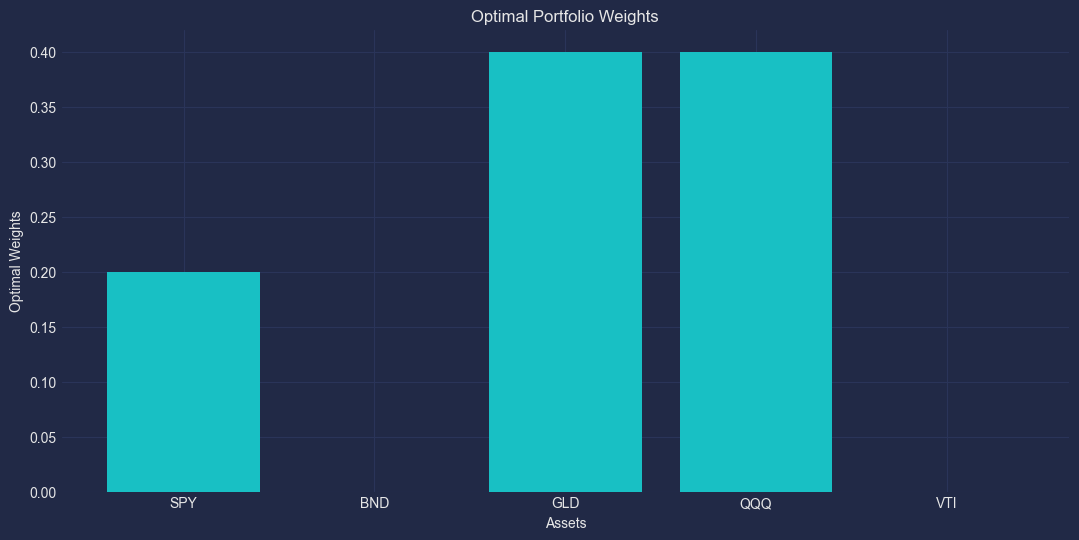

In [30]:
# Import
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Create a bar chart of the optimal weights
plt.figure(figsize=(13, 6))
plt.bar(tickers, optimal_weights)

# Add labels and title
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

# Show the plot
plt.show()